# Week 2 - Model Training

We will download the dataset prepared from the Dataset Preparation notebook and will begin model training to distinguish between the different main characters in Star Trek: The Next Generation

In [1]:
!wget -O tng.zip https://www.dropbox.com/s/3od3y6is3emoba0/tng_dataset.zip?dl=1

--2019-09-21 08:40:33--  https://www.dropbox.com/s/3od3y6is3emoba0/tng_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/3od3y6is3emoba0/tng_dataset.zip [following]
--2019-09-21 08:40:34--  https://www.dropbox.com/s/dl/3od3y6is3emoba0/tng_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0042a3136ac1b54a4ada25ebd.dl.dropboxusercontent.com/cd/0/get/Ao9D2yUBenJ8Iwmk_bDdyL9FjmSYDLdwUJHkmumy_VyNh4wzaCb595wcGxKb95dy-gHItm_rPil1cywXtbkp5J9_Kbkwm3vIsd-fxLQ9bBSIrswZq67WJsgt954UYN5ngM0/file?dl=1# [following]
--2019-09-21 08:40:34--  https://ucb0042a3136ac1b54a4ada25ebd.dl.dropboxusercontent.com/cd/0/get/Ao9D2yUBenJ8Iwmk_bDdyL9FjmSYDLdwUJHkmumy_VyNh4wzaCb595wcGxKb95dy-gHItm_rPil1cywXtbkp5J9_Kbkwm3vIsd-f

In [2]:
!unzip tng.zip

Archive:  tng.zip
   creating: tng_dataset/
   creating: tng_dataset/jean-luc-picard/
  inflating: tng_dataset/jean-luc-picard/00000038.jpg  
  inflating: tng_dataset/jean-luc-picard/00000004.jpg  
  inflating: tng_dataset/jean-luc-picard/00000206.png  
  inflating: tng_dataset/jean-luc-picard/00000005.jpg  
  inflating: tng_dataset/jean-luc-picard/00000011.jpg  
  inflating: tng_dataset/jean-luc-picard/00000039.jpg  
  inflating: tng_dataset/jean-luc-picard/00000171.jpg  
  inflating: tng_dataset/jean-luc-picard/00000165.jpg  
  inflating: tng_dataset/jean-luc-picard/00000159.jpg  
  inflating: tng_dataset/jean-luc-picard/00000173.jpg  
  inflating: tng_dataset/jean-luc-picard/00000167.jpg  
  inflating: tng_dataset/jean-luc-picard/00000007.jpg  
  inflating: tng_dataset/jean-luc-picard/00000239.jpg  
  inflating: tng_dataset/jean-luc-picard/00000210.jpg  
  inflating: tng_dataset/jean-luc-picard/00000252.gif  
  inflating: tng_dataset/jean-luc-picard/00000012.jpg  
  inflating: tng_d

Let's import the relevant libraries

In [0]:
from fastai import *
from fastai.vision import *

Because we've extracted out the data in the current directory, the training directory is also here.  Let's create an `ImageDataBunch` with the current directory.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path='.', train='./tng_dataset', valid_pct=0.1,
        ds_tfms=get_transforms(), size=299, num_workers=4).normalize(imagenet_stats)

Let's take a look at the classes.

In [8]:
data.classes

['beverly-crusher',
 'data',
 'deanna-troi',
 'geordi-la-forge',
 'jean-luc-picard',
 'katherine-pulaski',
 'tasha-yar',
 'wesley-crusher',
 'will-riker',
 'worf']

Let's have a look at the actual images - show an example batch

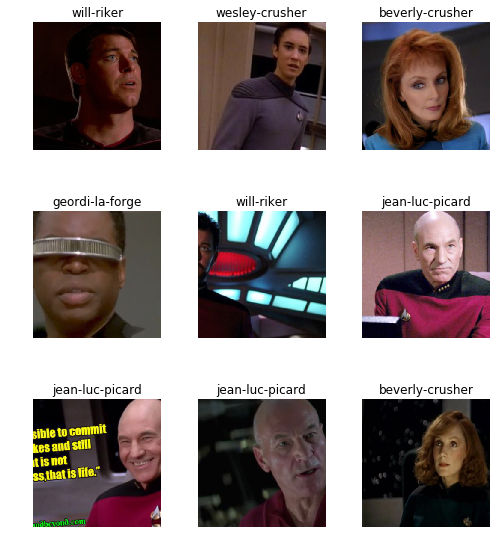

In [9]:
data.show_batch(rows=3, figsize=(7,8))

Show the number of classes, training and validation split

In [10]:
data.c, len(data.train_ds), len(data.valid_ds)

(10, 684, 75)

Load in ResNet50 and perform some transfer learning first

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 103940159.44it/s]


In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.006219,1.055704,0.746667,0.253333,00:44
1,1.235879,0.483581,0.880000,0.120000,00:25
2,0.878963,0.373235,0.933333,0.066667,00:25
3,0.676413,0.363351,0.906667,0.093333,00:25


Save the model before we start to train the whole network.  After, let's try and find the best learning rates for the conv and dense layers.

In [0]:
learn.save('./stage-1')

In [0]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


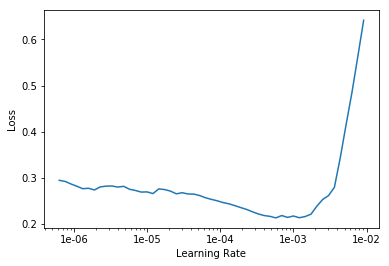

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.236943,0.311847,0.933333,0.066667,00:31
1,0.203833,0.405550,0.906667,0.093333,00:31
2,0.170391,0.404420,0.866667,0.133333,00:31
3,0.152622,0.366519,0.933333,0.066667,00:31
4,0.146429,0.426848,0.893333,0.106667,00:31
5,0.132607,0.213623,0.906667,0.093333,00:31
6,0.121190,0.196689,0.933333,0.066667,00:31
7,0.106588,0.149354,0.973333,0.026667,00:31
8,0.091146,0.139700,0.960000,0.040000,00:31
9,0.083944,0.132744,0.973333,0.026667,00:32


In [0]:
learn.save('./stage-2')

Great! The requirements say 80% accurate.  Let's plot the confusion matrix to be sure


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

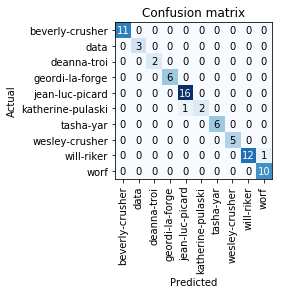

In [20]:
interp.plot_confusion_matrix()

Now export the model for production

In [0]:
learn.export('./models/tng_model.pkl')

Let's test some pictures out

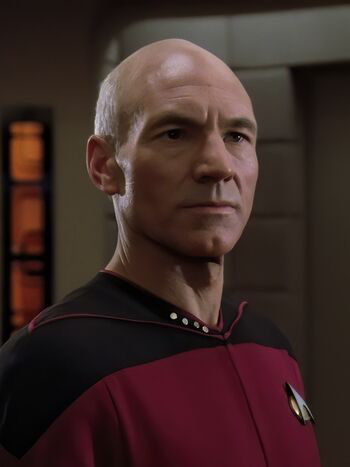

In [25]:
img = open_image('./tng_dataset/jean-luc-picard/00000000.jpg')
img

In [26]:
pred_class,pred_idx,outputs = learn.predict(img)
str(pred_class)

'jean-luc-picard'

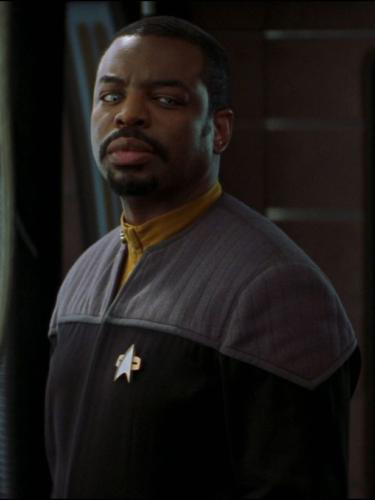

In [27]:
img = open_image('./tng_dataset/geordi-la-forge/00000003.jpg')
img

In [28]:
pred_class,_,_ = learn.predict(img)
str(pred_class)

'geordi-la-forge'

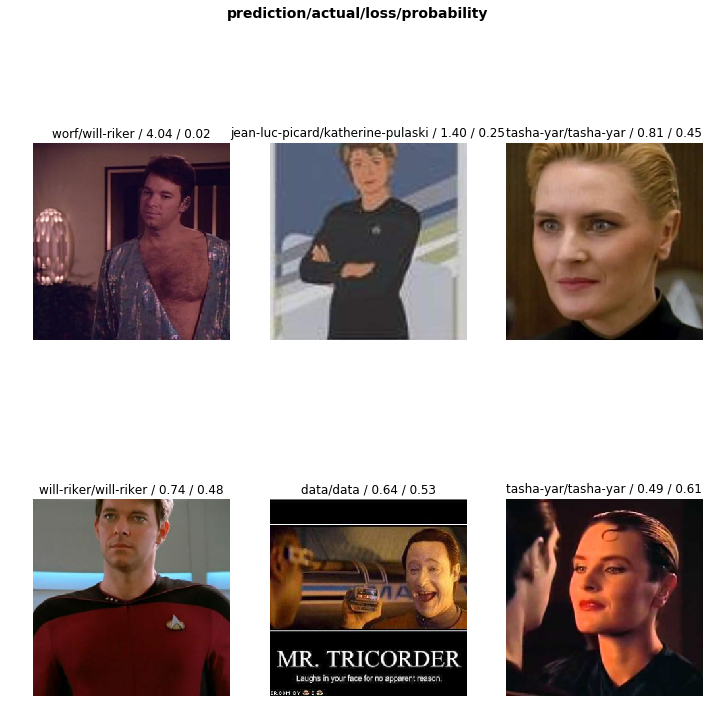

In [29]:
interp.plot_top_losses(6)